In [1]:
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline import Pipeline
from quantopian.pipeline import CustomFactor
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.filters import Q1500US, Q500US
from quantopian.pipeline.factors import AverageDollarVolume
import quantopian.pipeline.data.factset.estimates as fe
from quantopian.pipeline.classifiers.fundamentals import Sector
from quantopian.pipeline.data.factset.estimates import PeriodicConsensus
from quantopian.pipeline.experimental import risk_loading_pipeline

from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals
import alphalens as al

import numpy as np
import pandas as pd

MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

# Constraint Parameters
MAX_GROSS_LEVERAGE = 1.0
TOTAL_POSITIONS = 600
MAX_SHORT_POSITION_SIZE = 1.0 / TOTAL_POSITIONS
MAX_LONG_POSITION_SIZE = 1.0 / TOTAL_POSITIONS

/venvs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:14: ZiplineDeprecationWarning: PsychSignal datasets stopped updating on Quantopian on May 1, 2020.
PsychSignal data prior to May 2020 is still available for use on Quantopian;
however, the dataset has stopped updating. For more information see:
https://www.quantopian.com/posts/psychsignal-trader-mood-update

  


In [2]:
def make_pipeline():
    class Mean_Reversion_1M(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252//2

        def compute(self, today, assets, out, close):
            ret_1M = (close[-1] - close[-21]) / close[-21]
            ret_1Y_monthly = ((close[-1] - close[0]) / close[0]) / 6.
            out[:] = (ret_1M - np.nanmean(ret_1Y_monthly)) / \
                np.nanstd(ret_1Y_monthly)
    class ExpertsPredict(CustomFactor):   
            fq1_eps_cons = fe.PeriodicConsensus.slice('EPS', 'qf', 1)
            fq1_eps_cons_up = fq1_eps_cons.up
            fq1_eps_cons_down = fq1_eps_cons.down
            inputs = [fq1_eps_cons_up,
                      fq1_eps_cons_down]
            window_length = 1
            def compute(self, today, assets, out, up, down):
                ratio_1 = up[-1] - down[-1]
                out[:] = ratio_1 
    class Log_Market_Cap(CustomFactor):
        inputs = [morningstar.valuation.market_cap]
        window_length = 1

        def compute(self, today, assets, out, mc):
            out[:] = np.log(mc[-1])  
            
    value = Fundamentals.ebit.latest / Fundamentals.enterprise_value.latest
    quality = Fundamentals.roe.latest
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )

    universe = QTradableStocksUS()

    # We winsorize our factor values in order to lessen the impact of outliers
    # For more information on winsorization, please see
    # https://en.wikipedia.org/wiki/Winsorizing
    value_winsorized = value.winsorize(min_percentile=0.05, max_percentile=0.95)
    quality_winsorized = quality.winsorize(min_percentile=0.05, max_percentile=0.95)
    mean_reversion = Mean_Reversion_1M().winsorize(min_percentile=0.05, max_percentile=0.95)
    sentiment_score_winsorized = sentiment_score.winsorize(
        min_percentile=0.05,
        max_percentile=0.95
        )
    experts = ExpertsPredict().winsorize(min_percentile=0.05, max_percentile=0.95)
    mk_cap = Log_Market_Cap().winsorize(min_percentile=0.05, max_percentile=0.95)
    # Here we combine our winsorized factors, z-scoring them to equalize their influence
    combined_factor = (
        0.2*value_winsorized.zscore() +
        0.2*quality_winsorized.zscore() +
        0.2*sentiment_score_winsorized.zscore()-
        mean_reversion.zscore()+
        experts+
        0.5*mk_cap
    )

    # Build Filters representing the top and bottom baskets of stocks by our
    # combined ranking system. We'll use these as our tradeable universe each
    # day.
    longs = combined_factor.top(TOTAL_POSITIONS//2, mask=universe)
    shorts = combined_factor.bottom(TOTAL_POSITIONS//2, mask=universe)

    # The final output of our pipeline should only include
    # the top/bottom 300 stocks by our criteria
    long_short_screen = (longs | shorts)

    # Create pipeline
    pipe = Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts,
            'combined_factor': combined_factor,
            'Sector':Sector()
        },
        screen=long_short_screen
    )
    return pipe

In [3]:
# Import run_pipeline method
from quantopian.research import run_pipeline

# Specify a time range to evaluate
period_start = '2011-01-01'
period_end = '2012-01-01'

# Execute pipeline over evaluation period
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date=period_start,
    end_date=period_end
)

In [4]:
sectors = pipeline_output['Sector']
asset_list = pipeline_output.index.levels[1].unique()


prices = get_pricing(asset_list, start_date=period_start, end_date=period_end, fields='open_price')


In [5]:
periods = (1, 3, 5)
factor_data = al.utils.get_clean_factor_and_forward_returns(factor=pipeline_output['combined_factor'],
                                                            prices=prices,
                                                            groupby=sectors,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            periods=periods)

Dropped 2.4% entries from factor data: 2.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-3.488222,7.489876,2.242485,1.833919,29640,20.003104
2,0.477745,8.479268,3.854806,1.687563,29639,20.002430
3,2.025687,17.379666,9.907824,5.078889,29619,19.988932
4,12.682833,19.454114,16.208996,1.273901,29639,20.002430
5,13.881717,22.309776,17.958638,1.305592,29640,20.003104


Returns Analysis


,1D,3D,5D
Ann. alpha,0.088,0.077,0.072
beta,0.004,0.007,0.008
Mean Period Wise Return Top Quantile (bps),3.901,3.457,3.348
Mean Period Wise Return Bottom Quantile (bps),-4.778,-4.933,-4.492
Mean Period Wise Spread (bps),8.679,8.389,7.836


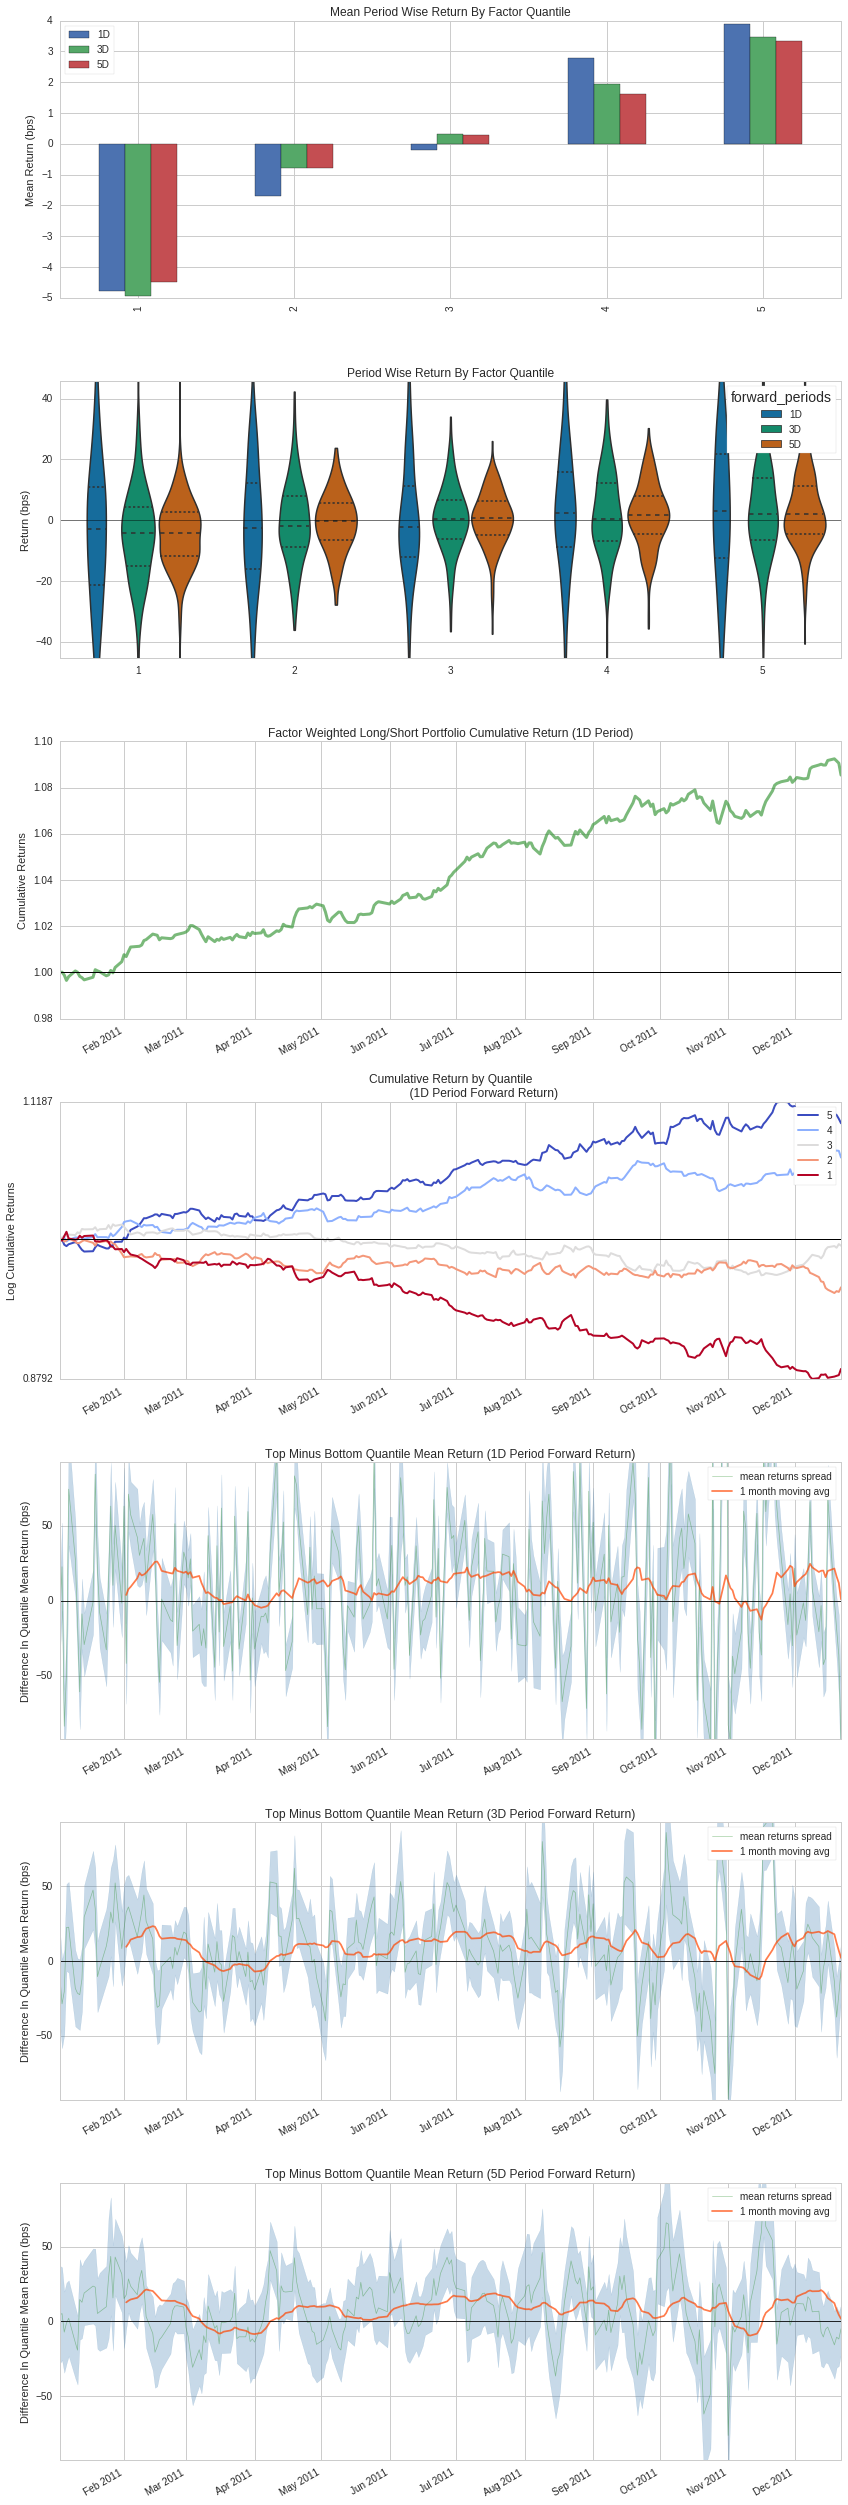

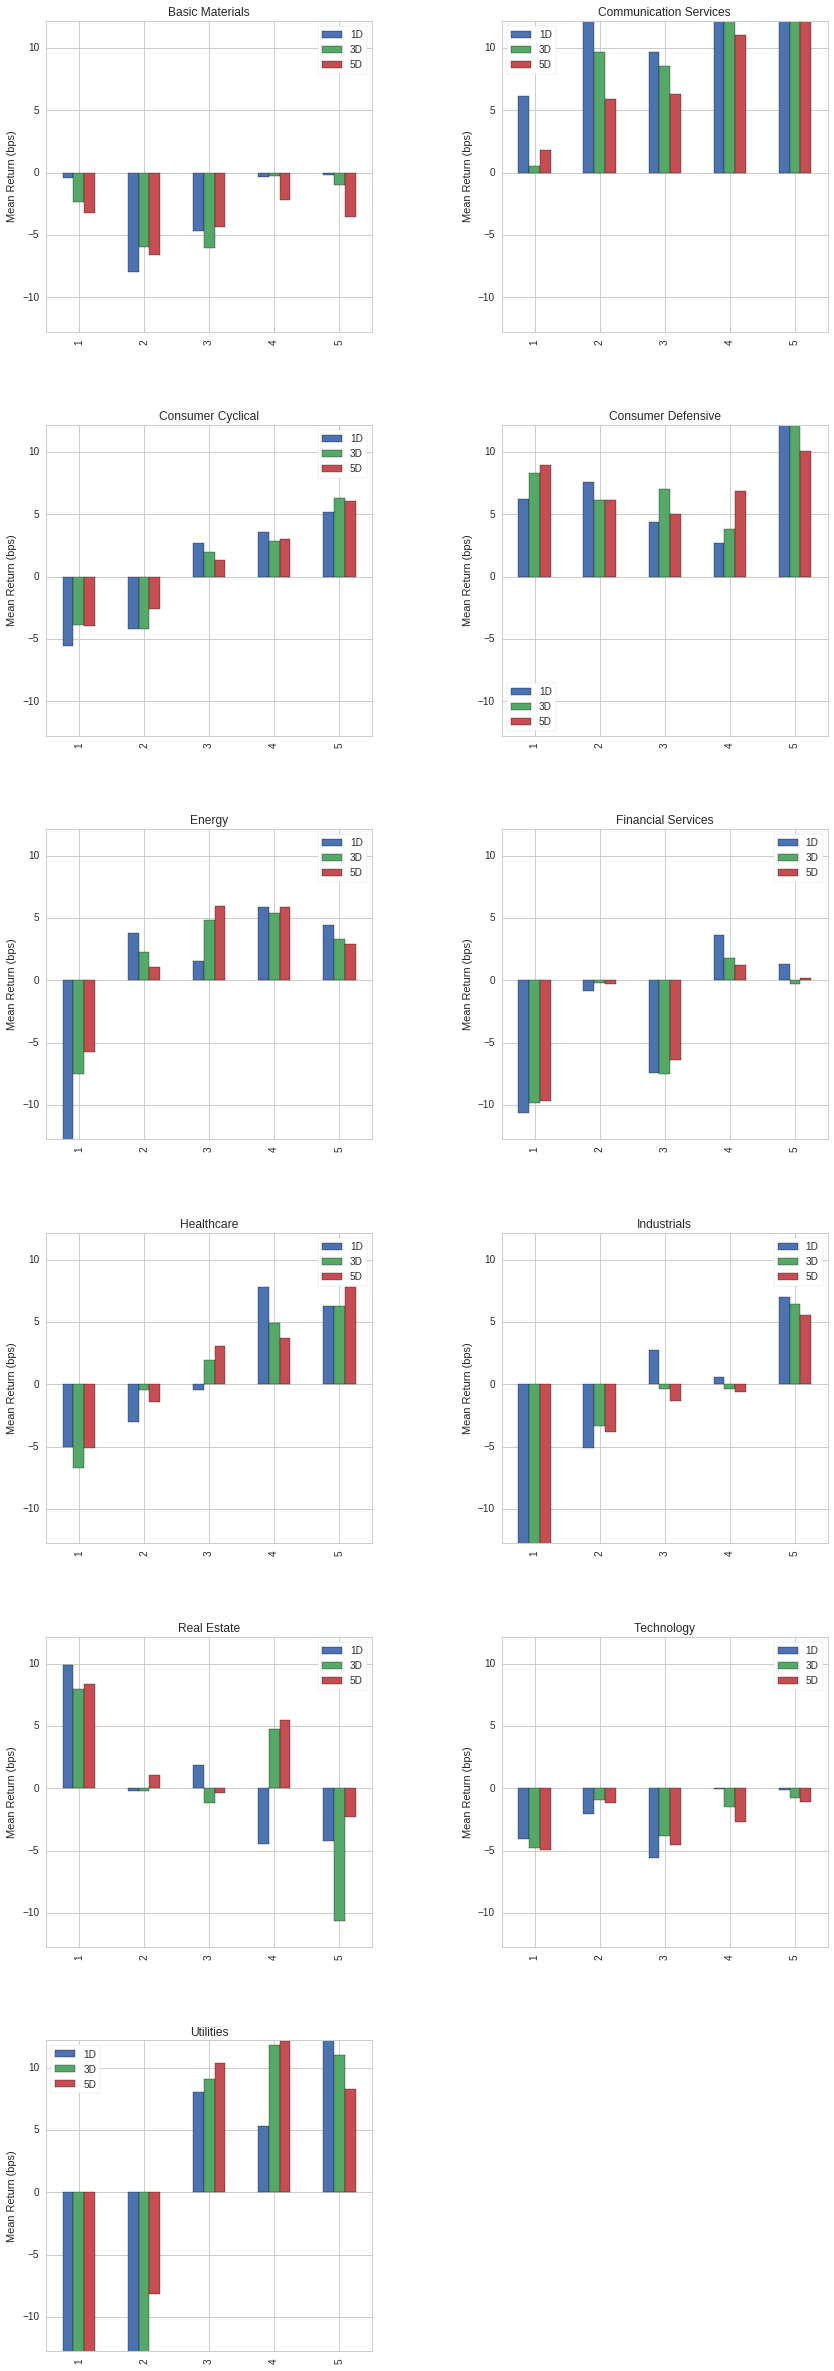

Information Analysis


,1D,3D,5D
IC Mean,0.021,0.035,0.039
IC Std.,0.089,0.092,0.090
Risk-Adjusted IC,0.239,0.378,0.432
t-stat(IC),3.759,5.948,6.795
p-value(IC),0.000,0.000,0.000
IC Skew,0.081,0.052,0.021
IC Kurtosis,-0.117,-0.428,-0.304


/venvs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


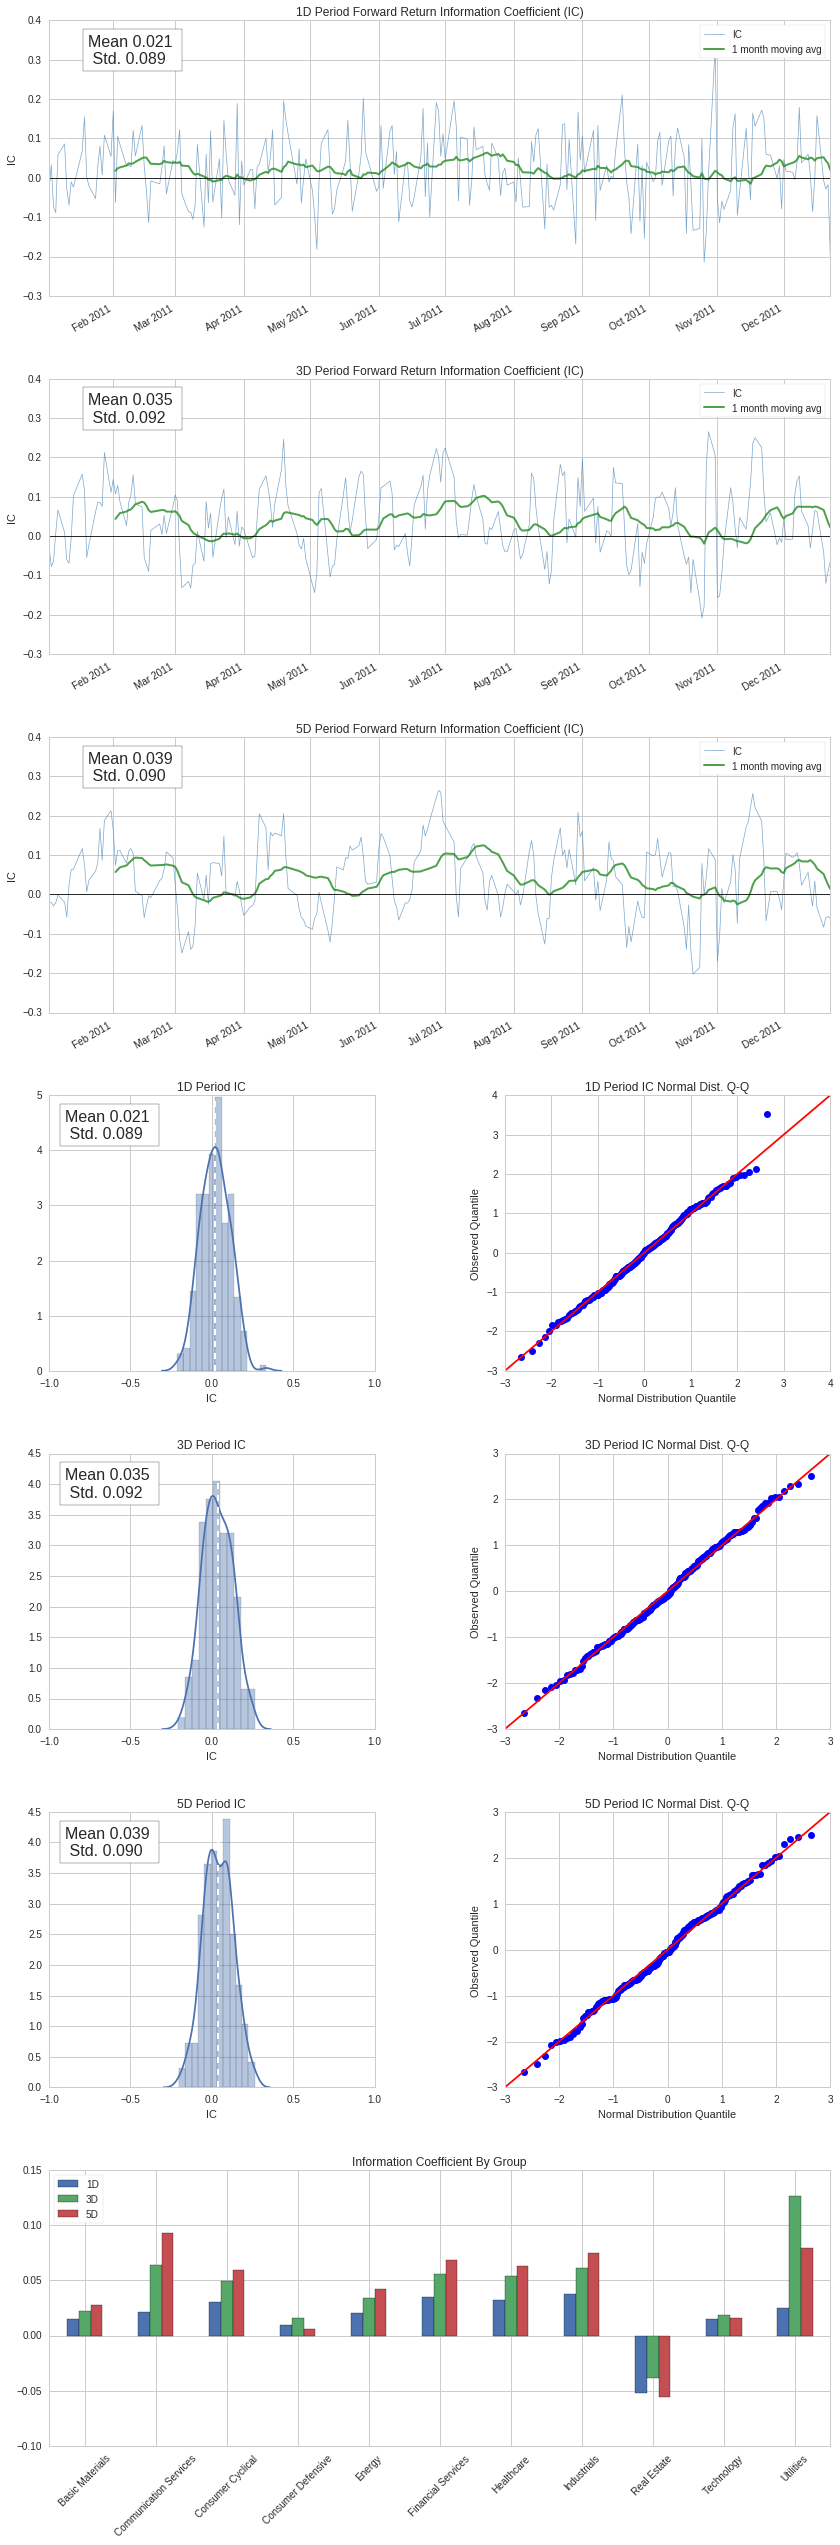

/venvs/py35/lib/python3.5/site-packages/alphalens/utils.py:912: UserWarning: Skipping return periods that aren't exact multiples of days.
  + " of days."


Turnover Analysis


,1D,3D,5D
Quantile 1 Mean Turnover,0.130,0.247,0.327
Quantile 2 Mean Turnover,0.230,0.401,0.496
Quantile 3 Mean Turnover,0.373,0.593,0.685
Quantile 4 Mean Turnover,0.209,0.373,0.464
Quantile 5 Mean Turnover,0.115,0.220,0.292


,1D,3D,5D
Mean Factor Rank Autocorrelation,0.98,0.947,0.919


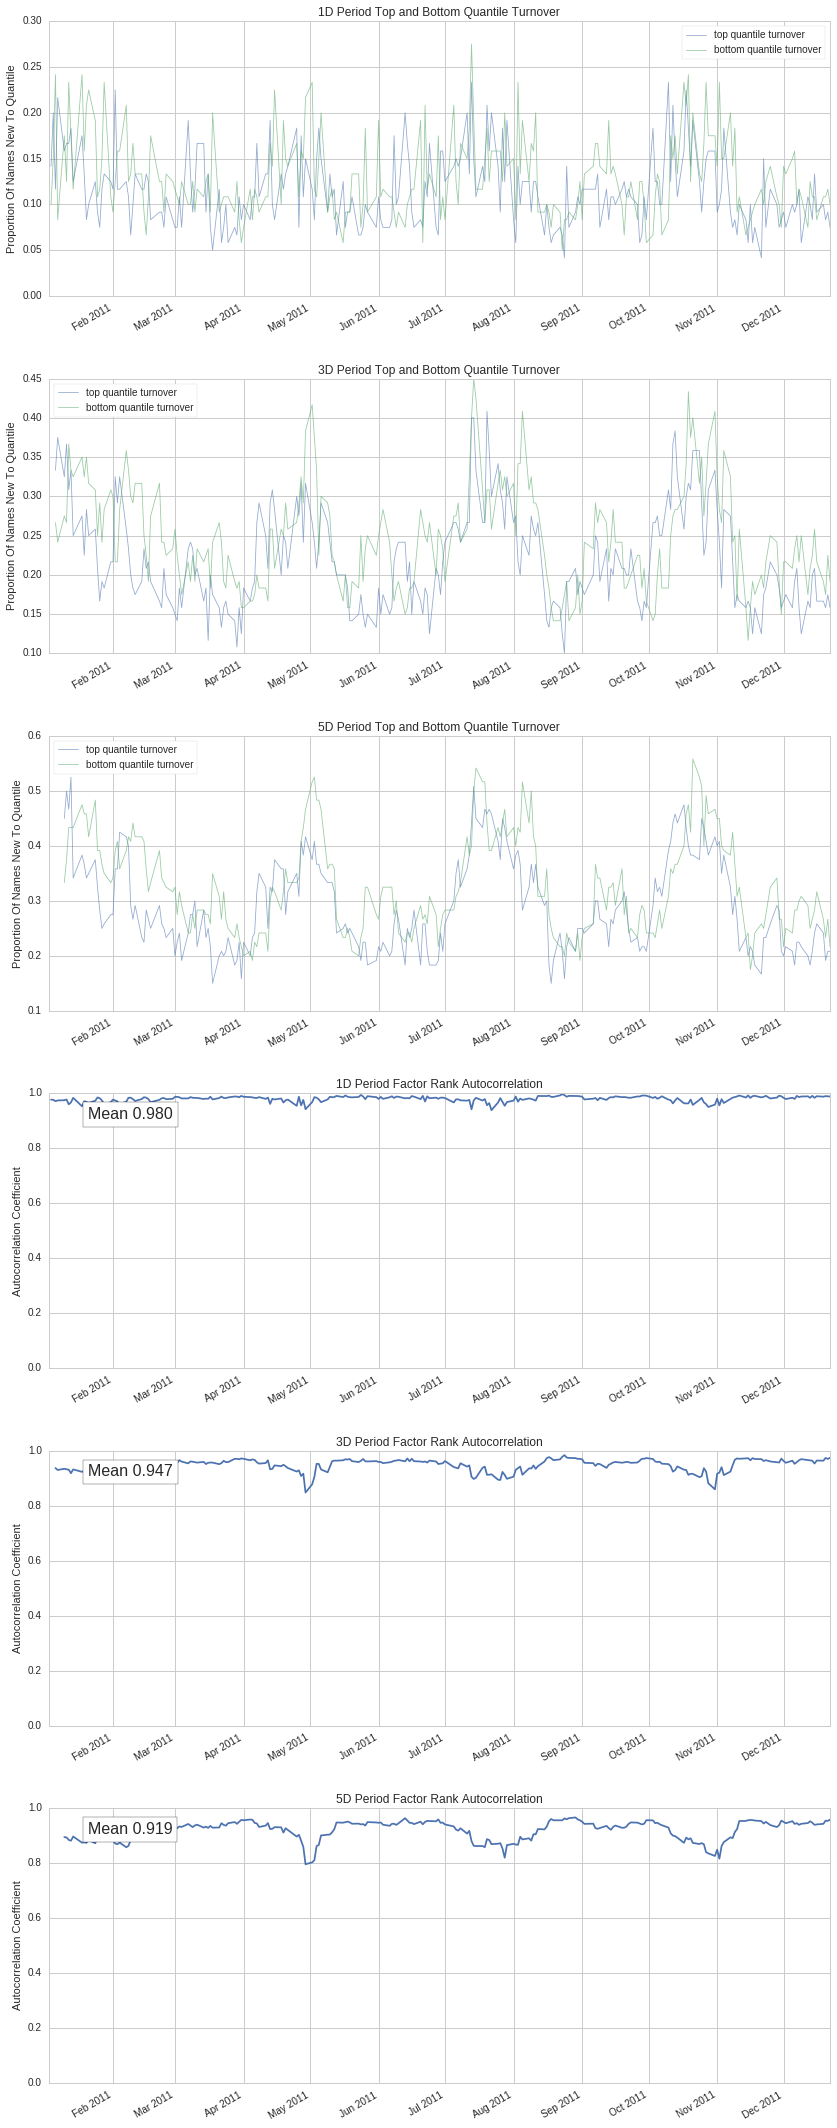

In [6]:
al.tears.create_full_tear_sheet(factor_data, by_group=True);